In [1]:
train_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Train' 
val_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Val' 
test_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Test'

In [2]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 100, 100 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 2 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size
 

Using TensorFlow backend.


In [3]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 14507 images belonging to 2 classes.
Found 3615 images belonging to 2 classes.
Found 4535 images belonging to 2 classes.


In [4]:
train=train_generator
val=validation_generator
test=test_generator

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet152V2, NASNetLarge
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

densenet121_model = DenseNet121(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

densenet121_model.trainable=True

In [ ]:
#for layer in Xception_model.layers[:-40]:
#    layer.trainable = False

In [6]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in densenet121_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\elium\.conda\envs\tfGPU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001F75A661C88>,input_1,True
1,<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x000001F764792E88>,zero_padding2d,True
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F764629EC8>,conv1/conv,True
3,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001F76272A948>,conv1/bn,True
4,<tensorflow.python.keras.layers.core.Activation object at 0x000001F764F69F88>,conv1/relu,True
...,...,...,...
422,<tensorflow.python.keras.layers.core.Activation object at 0x000001F9E8798E88>,conv5_block16_1_relu,True
423,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F9E879CC48>,conv5_block16_2_conv,True
424,<tensorflow.python.keras.layers.merge.Concatenate object at 0x000001F9E87F6A88>,conv5_block16_concat,True
425,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001F9E6C30408>,bn,True


In [7]:
densenet121_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [8]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [9]:

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical 
from keras import optimizers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
# build model architecture 
model = Sequential()
model.add(densenet121_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_class, activation='sigmoid'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 3, 3, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 5

In [23]:
history = model.fit_generator(train, steps_per_epoch=100, 
                              epochs=80,  
                              validation_data=val,   
                              validation_steps=50,  
                              verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/80
100/100 [==============================] - 10s 97ms/step - loss: 0.3242 - accuracy: 0.9915 - f1_m: 0.9917 - precision_m: 0.9919 - recall_m: 0.9916 - val_loss: 0.3535 - val_accuracy: 0.9588 - val_f1_m: 0.9586 - val_precision_m: 0.9561 - val_recall_m: 0.9613
Epoch 2/80
100/100 [==============================] - 9s 93ms/step - loss: 0.3243 - accuracy: 0.9912 - f1_m: 0.9911 - precision_m: 0.9912 - recall_m: 0.9909 - val_loss: 0.3528 - val_accuracy: 0.9606 - val_f1_m: 0.9598 - val_precision_m: 0.9572 - val_recall_m: 0.9625
Epoch 3/80
100/100 [==============================] - 9s 93ms/step - loss: 0.3233 - accuracy: 0.9928 - f1_m: 0.9927 - precision_m: 0.9928 - recall_m: 0.9925 - val_loss: 0.3562 - val_accuracy: 0.9544 - val_f1_m: 0.9541 - val_precision_m: 0.9528 - val_recall_m: 0.9556
Epoch 4/80
100/100 [==============================] - 10s 96ms/step - loss: 0.3237 - accuracy: 0.9922 - f

Epoch 31/80
100/100 [==============================] - 9s 94ms/step - loss: 0.3216 - accuracy: 0.9931 - f1_m: 0.9931 - precision_m: 0.9931 - recall_m: 0.9931 - val_loss: 0.3549 - val_accuracy: 0.9556 - val_f1_m: 0.9572 - val_precision_m: 0.9558 - val_recall_m: 0.9588
Epoch 32/80
100/100 [==============================] - 9s 94ms/step - loss: 0.3236 - accuracy: 0.9912 - f1_m: 0.9911 - precision_m: 0.9912 - recall_m: 0.9909 - val_loss: 0.3544 - val_accuracy: 0.9563 - val_f1_m: 0.9564 - val_precision_m: 0.9530 - val_recall_m: 0.9600
Epoch 33/80
100/100 [==============================] - 9s 94ms/step - loss: 0.3238 - accuracy: 0.9909 - f1_m: 0.9909 - precision_m: 0.9909 - recall_m: 0.9909 - val_loss: 0.3551 - val_accuracy: 0.9550 - val_f1_m: 0.9544 - val_precision_m: 0.9533 - val_recall_m: 0.9556
Epoch 34/80
100/100 [==============================] - 9s 95ms/step - loss: 0.3215 - accuracy: 0.9934 - f1_m: 0.9933 - precision_m: 0.9932 - recall_m: 0.9934 - val_loss: 0.3541 - val_accuracy: 0.9

100/100 [==============================] - 9s 94ms/step - loss: 0.3202 - accuracy: 0.9940 - f1_m: 0.9942 - precision_m: 0.9944 - recall_m: 0.9941 - val_loss: 0.3534 - val_accuracy: 0.9569 - val_f1_m: 0.9570 - val_precision_m: 0.9553 - val_recall_m: 0.9588
Epoch 62/80
100/100 [==============================] - 9s 94ms/step - loss: 0.3209 - accuracy: 0.9934 - f1_m: 0.9933 - precision_m: 0.9934 - recall_m: 0.9931 - val_loss: 0.3546 - val_accuracy: 0.9550 - val_f1_m: 0.9554 - val_precision_m: 0.9540 - val_recall_m: 0.9569
Epoch 63/80
100/100 [==============================] - 9s 95ms/step - loss: 0.3207 - accuracy: 0.9934 - f1_m: 0.9934 - precision_m: 0.9935 - recall_m: 0.9934 - val_loss: 0.3544 - val_accuracy: 0.9569 - val_f1_m: 0.9560 - val_precision_m: 0.9546 - val_recall_m: 0.9575
Epoch 64/80
100/100 [==============================] - 9s 95ms/step - loss: 0.3199 - accuracy: 0.9944 - f1_m: 0.9944 - precision_m: 0.9944 - recall_m: 0.9944 - val_loss: 0.3541 - val_accuracy: 0.9581 - val_f1

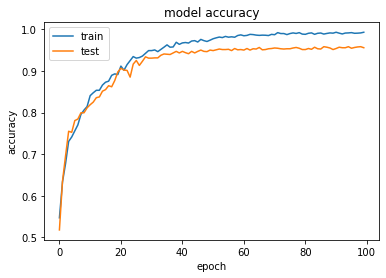

In [11]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

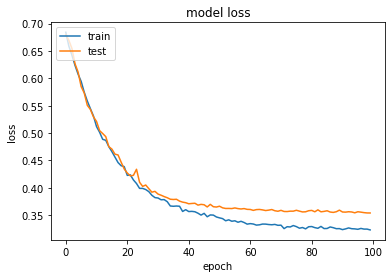

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

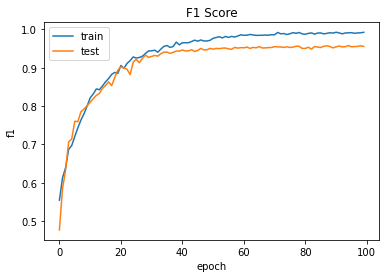

In [13]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

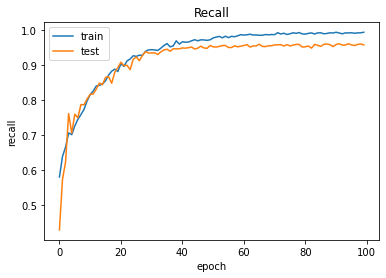

In [14]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

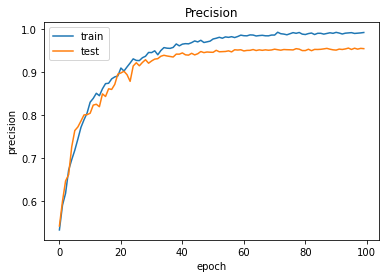

In [15]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos de test para evaluar el modelo
  ...
    to  
  ['...']
142/142 [==============================] - 6s 39ms/step - loss: 0.3502 - accuracy: 0.9621 - f1_m: 0.9614 - precision_m: 0.9607 - recall_m: 0.9621
El modelo predice el  96.20727896690369 % de los datos


In [25]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos de test para evaluar el modelo
Loss:  0.3502243469718476
Accuracy:  0.9620728
F1 Score:  0.96139395
Precision:  0.9607449
Recall:  0.9621096


In [26]:
articulo_dir='D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Implementacion/Deteccion_Articulo/dataset,solocovid,pneumonia'
#Para el conjunto del artículo
articulo_generator = train_datagen.flow_from_directory(
    articulo_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data
articulo=articulo_generator

Found 351 images belonging to 2 classes.


In [27]:
print('Utilizando el conjunto de datos del artículo para evaluar el modelo')
test_eval = model.evaluate(articulo, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos del artículo para evaluar el modelo
  ...
    to  
  ['...']
11/11 [==============================] - 4s 399ms/step - loss: 0.4535 - accuracy: 0.8547 - f1_m: 0.8547 - precision_m: 0.8523 - recall_m: 0.8572
El modelo predice el  85.47008633613586 % de los datos


In [28]:
print('Utilizando el conjunto de datos del artículo para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos del artículo para evaluar el modelo
Loss:  0.453494440425526
Accuracy:  0.85470086
F1 Score:  0.8547302
Precision:  0.8523144
Recall:  0.8572214


In [29]:
print('180 eponchs')

180 eponchs


In [30]:
# Guardar el Modelo
model.save('modelDensenet121Covidysanos.h5')

In [31]:
pred=model.predict(articulo)

In [32]:
#Aquí sólo hago con  un predict con el modelo y los datos del artículo
import numpy as np
suma=0
for i in range (351):
    if np.argmax(pred[i])==0:
        suma=suma+1
print(suma)

148
